In [4]:
from collections import defaultdict
from datetime import datetime
import dill
from itertools import permutations, combinations
import json
from operator import itemgetter
import os
import pickle
import random
import re
import time

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
sns.set(style='ticks', font_scale=1.2)

import little_mallet_wrapper

In [5]:
import imp
imp.reload(little_mallet_wrapper)

<module 'little_mallet_wrapper' from '/Users/mah343/Documents/projects/birth-control/little_mallet_wrapper.py'>

In [6]:
base_path = '/Volumes/Maria\'s Black Passport/data/birth-control'

bc_comments_path = base_path + '/bc_comments.csv'
bc_posts_path    = base_path + '/bc_topicposts.csv'

output_directory_path = '/Volumes/Maria\'s Black Passport/output/birth-control'

MALLET_PATH = '/Users/mah343/Documents/packages/mallet-2.0.8/bin/mallet'

<br><br>

# Load posts

In [11]:
posts_df = pd.read_csv(bc_posts_path)

posts_df = posts_df.set_index('id', drop=False)

posts_df.sample(10)

,author,created_utc,distinguished,domain,from_,from_id,from_kind,gilded,id,is_self,...,score,selftext,stickied,subreddit,subreddit_id,thumbnail,title,url,ups,downs
id,,,,,,,,,,,,,,,,,,,,,
17ujtd,[deleted],1359951592,NaN,self.birthcontrol,NaN,NaN,NaN,0.0,17ujtd,t,...,1,I decided to give Micronor (minipill) a try f...,f,birthcontrol,t5_2snsq,default,Dizziness as a side effect,http://www.reddit.com/r/birthcontrol/comments/...,1.0,0.0
jrd2j,[deleted],1314074197,NaN,self.birthcontrol,NaN,NaN,NaN,NaN,jrd2j,t,...,1,So I've been on Loestrin FE for four months no...,NaN,birthcontrol,t5_2snsq,default,Question about Loestrin FE,http://www.reddit.com/r/birthcontrol/comments/...,1.0,0.0
78xvj4,gr0wl1ng,1509045510,NaN,self.birthcontrol,NaN,NaN,NaN,0.0,78xvj4,t,...,2,I suffer from manic depression and am current ...,f,birthcontrol,t5_2snsq,self,Mirena and depression?,https://www.reddit.com/r/birthcontrol/comments...,NaN,NaN
2ojfy7,[deleted],1417945379,NaN,self.birthcontrol,NaN,NaN,NaN,0.0,2ojfy7,t,...,8,"Right now I'm on Zenchent, which has worked fi...",f,birthcontrol,t5_2snsq,default,"I'd love to not have periods, but I do like a ...",http://www.reddit.com/r/birthcontrol/comments/...,8.0,0.0
2nhh85,freakydeeky105,1417016404,NaN,self.birthcontrol,NaN,NaN,NaN,0.0,2nhh85,t,...,1,I'm a 34/f with unexplained infertility. Kids ...,f,birthcontrol,t5_2snsq,self,Shorter cycle - hormonal IUD or normal functio...,http://www.reddit.com/r/birthcontrol/comments/...,1.0,0.0
5tg8q2,ynok822,1486834528,NaN,self.birthcontrol,NaN,NaN,NaN,0.0,5tg8q2,t,...,11,"I'm a nulliparous, 24 year old woman and I had...",f,birthcontrol,t5_2snsq,self,My Paragard IUD insertion experience,https://www.reddit.com/r/birthcontrol/comments...,NaN,NaN
4jm6g0,[deleted],1463418928,NaN,self.birthcontrol,NaN,NaN,NaN,0.0,4jm6g0,t,...,2,[deleted],f,birthcontrol,t5_2snsq,default,Possibilities of becoming pregnant directly af...,https://www.reddit.com/r/birthcontrol/comments...,2.0,0.0
21pce7,[deleted],1396132355,NaN,self.birthcontrol,NaN,NaN,NaN,0.0,21pce7,t,...,1,beh.,f,birthcontrol,t5_2snsq,default,"took planb after broken condom, last time I to...",http://www.reddit.com/r/birthcontrol/comments/...,1.0,0.0
2nn48x,MyKindOfLullaby,1417151484,NaN,self.birthcontrol,NaN,NaN,NaN,0.0,2nn48x,t,...,3,I just got an IUD last week (mirena). I can fe...,f,birthcontrol,t5_2snsq,self,"When checking an IUD string, how do I know it'...",http://www.reddit.com/r/birthcontrol/comments/...,3.0,0.0


In [131]:
print(len(posts_df.index))

posts_df = posts_df.loc[~posts_df.index.duplicated(keep='first')]

print(len(posts_df.index))

32627
32627


In [12]:
for col in posts_df.columns: 
    print(col) 

author
created_utc
distinguished
domain
from_
from_id
from_kind
gilded
id
is_self
link_flair_text
name
num_comments
over_18
permalink
quarantine
retrieved_on
score
selftext
stickied
subreddit
subreddit_id
thumbnail
title
url
ups
downs


In [13]:
posts_df = posts_df.filter(['author', 
                            'created_utc', 
                            'gilded',
                            'id',
                            'link_flair_text',
                            'name',
                            'num_comments',
                            'over_18',
                            'permalink',
                            'title',
                            'selftext',
                            'url',
                            'ups',
                            'downs'], axis=1)

posts_df.sample(5)

,author,created_utc,gilded,id,link_flair_text,name,num_comments,over_18,permalink,title,selftext,url,ups,downs
id,,,,,,,,,,,,,,
5cyo11,119cm,1479160396,0.0,5cyo11,Other,t3_5cyo11,5,f,/r/birthcontrol/comments/5cyo11/insurance_no_l...,Insurance no longer covers Beyaz - what to do ...,I was on Beyaz for a while in 2015 but ended u...,https://www.reddit.com/r/birthcontrol/comments...,5.0,0.0
7235bl,breeee19,1506227532,0.0,7235bl,Which Method?,NaN,16,f,/r/birthcontrol/comments/7235bl/should_i_get_n...,Should I get Nexplanon or IUD?,I've been on BCP for more than a year now and ...,https://www.reddit.com/r/birthcontrol/comments...,NaN,NaN
30kft6,[deleted],1427513905,0.0,30kft6,NaN,t3_30kft6,1,f,/r/birthcontrol/comments/30kft6/paragard_birth...,Paragard + birth control pills?,"Hey guys, I was just wondering if anyone here ...",http://www.reddit.com/r/birthcontrol/comments/...,2.0,0.0
5oe3u5,Cj1181wool,1484606850,0.0,5oe3u5,Side Effects!?,NaN,7,f,/r/birthcontrol/comments/5oe3u5/is_my_iud_expe...,Is my IUD expelling?,I didn't feel anything (albeit I didn't try ve...,https://www.reddit.com/r/birthcontrol/comments...,NaN,NaN
2x378m,laurjayne,1424847502,0.0,2x378m,NaN,t3_2x378m,0,f,/r/birthcontrol/comments/2x378m/free_birth_con...,Free Birth Control?,I doubt anyone will see this. I just moved to ...,http://www.reddit.com/r/birthcontrol/comments/...,1.0,0.0


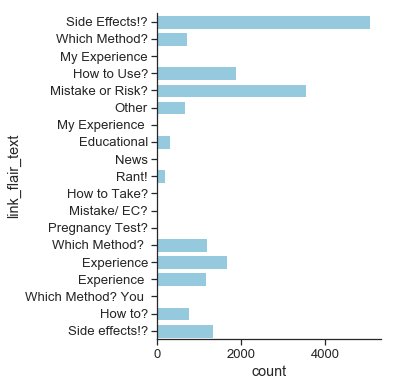

In [14]:
plt.figure(figsize=(4, 6))
sns.countplot(data=posts_df,
              y='link_flair_text',
              color='skyblue')
sns.despine()

In [15]:
posts_df['Year'] = posts_df['created_utc'].apply(lambda x: time.gmtime(int(x)).tm_year)

posts_df.sample(5)

,author,created_utc,gilded,id,link_flair_text,name,num_comments,over_18,permalink,title,selftext,url,ups,downs,Year
id,,,,,,,,,,,,,,,
1wxgxa,[deleted],1391465186,0.0,1wxgxa,NaN,t3_1wxgxa,2,f,/r/birthcontrol/comments/1wxgxa/lo_loestrin_fe...,Lo Loestrin Fe Question...,This is my second time submitting here about t...,http://www.reddit.com/r/birthcontrol/comments/...,1.0,0.0,2014
2oea2a,[deleted],1417811808,0.0,2oea2a,NaN,t3_2oea2a,11,f,/r/birthcontrol/comments/2oea2a/does_anyone_ha...,Does anyone have burning after sex with nuvaring?,I recently got nuvaring and the first time I h...,http://www.reddit.com/r/birthcontrol/comments/...,3.0,0.0,2014
5x7hdk,GandalfTheGr3y,1488504821,0.0,5x7hdk,Side Effects!?,NaN,13,f,/r/birthcontrol/comments/5x7hdk/help_dont_know...,HELP! - Don't know what just happened,"So, after being on the pill for only a short t...",https://www.reddit.com/r/birthcontrol/comments...,NaN,NaN,2017
5p11he,Syflan,1484877031,0.0,5p11he,Mistake or Risk?,NaN,1,f,/r/birthcontrol/comments/5p11he/jadelle_arm_im...,Jadelle Arm Implant 4.5 years after installation,My girlfriend has the Jaadelle 2-rod arm impla...,https://www.reddit.com/r/birthcontrol/comments...,NaN,NaN,2017
4gi5i5,DudeBored,1461665384,0.0,4gi5i5,Experience,t3_4gi5i5,1,f,/r/birthcontrol/comments/4gi5i5/nexplanon_pinc...,Nexplanon pinching?,Hey everyone. I switched from Mirena to Nexpla...,https://www.reddit.com/r/birthcontrol/comments...,3.0,0.0,2016


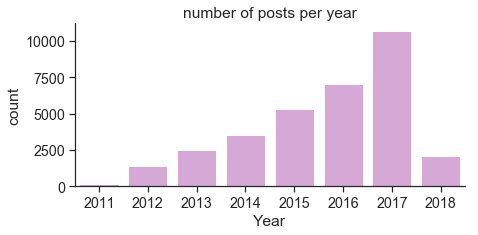

In [16]:
sns.set(style='ticks', font_scale=1.3)
plt.figure(figsize=(7,3))
sns.countplot(data=posts_df,
              x='Year',
              color='plum')
plt.title('number of posts per year')
sns.despine()

In [35]:
# def get_score(ups, downs):
#     if not pd.isnull(ups) and not pd.isnull(downs):
#         return ups - downs
#     return 0
    

# posts_df['Score'] = posts_df.apply(lambda _row: get_score(_row['ups'], _row['downs']))

# posts_df.sample(5)

<br><br>

# Load comments

In [18]:
comments_df = pd.read_csv(bc_comments_path)

comments_df = comments_df.set_index('id', drop=False)

len(comments_df.index)

comments_df.sample(5)

/Users/mah343/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (8,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,author,body,controversiality,created_utc,gilded,id,link_id,parent_id,permalink,retrieved_on,score,stickied,subreddit,subreddit_id,ups,downs
id,,,,,,,,,,,,,,,,
dvwf9dr,Alexis0815,I never thought about double rinsing my underw...,0,1521395133,0,dvwf9dr,t3_85915z,t1_dvw8lao,/r/birthcontrol/comments/85915z/bacterial_vagi...,1.525305e+09,1,f,birthcontrol,t5_2snsq,NaN,NaN
dtmxhl0,liddleMissSunshiine,For how long have you been feeling this? Did i...,0,1517595117,0,dtmxhl0,t3_7usz2x,t3_7usz2x,/r/birthcontrol/comments/7usz2x/i_am_on_depo_a...,1.518865e+09,2,f,birthcontrol,t5_2snsq,NaN,NaN
c942enz,thepastweown1,probably,0,1364486369,0,c942enz,t3_19u7p9,t1_c93958y,NaN,1.431732e+09,1,NaN,birthcontrol,t5_2snsq,1.0,0.0
d0hcdxd,LizzieCLems,"Okay, that makes sense, I'll just let them kno...",0,1456698882,0,d0hcdxd,t3_4856gw,t1_d0hbzae,NaN,1.458802e+09,1,f,birthcontrol,t5_2snsq,1.0,NaN
cuvmxks,swagg_muffin,"No, she respects me for using condoms, it's ju...",0,1441810951,0,cuvmxks,t3_3k82ez,t1_cuvlu2i,NaN,1.444257e+09,1,NaN,birthcontrol,t5_2snsq,1.0,NaN


In [19]:
for col in comments_df.columns: 
    print(col) 

author
body
controversiality
created_utc
gilded
id
link_id
parent_id
permalink
retrieved_on
score
stickied
subreddit
subreddit_id
ups
downs


In [20]:
comments_df['Year'] = comments_df['created_utc'].apply(lambda x: time.gmtime(int(x)).tm_year)

comments_df.sample(5)

,author,body,controversiality,created_utc,gilded,id,link_id,parent_id,permalink,retrieved_on,score,stickied,subreddit,subreddit_id,ups,downs,Year
id,,,,,,,,,,,,,,,,,
dpicgjw,traveler_mar,"You don’t get a period on the pill, it’s a wit...",0,1510114086,0,dpicgjw,t3_7bihd1,t3_7bihd1,/r/birthcontrol/comments/7bihd1/birth_control/...,1.512417e+09,2,f,birthcontrol,t5_2snsq,NaN,NaN,2017
cnxktz8,shmookieguinz,A generic version of your pill isn't going to ...,0,1421960901,0,cnxktz8,t3_2tbm5h,t3_2tbm5h,NaN,1.424451e+09,2,NaN,birthcontrol,t5_2snsq,2.0,0.0,2015
cd12jyc,Curiosities,"Check your pamphlet for specifics, but most co...",0,1382927739,0,cd12jyc,t3_1pc751,t3_1pc751,NaN,1.428959e+09,4,NaN,birthcontrol,t5_2snsq,4.0,0.0,2013
chdxwv7,andrewiknowyou,"No. As soon as you go off the pill, you are fe...",0,1399668488,0,chdxwv7,t3_255948,t3_255948,NaN,1.433727e+09,2,NaN,birthcontrol,t5_2snsq,2.0,0.0,2014
delk8gl,pinkpol,ooooh how could I forget that about nuvaring!!...,0,1488848580,0,delk8gl,t3_5xwt67,t1_delk0y4,NaN,1.491272e+09,1,f,birthcontrol,t5_2snsq,NaN,NaN,2017


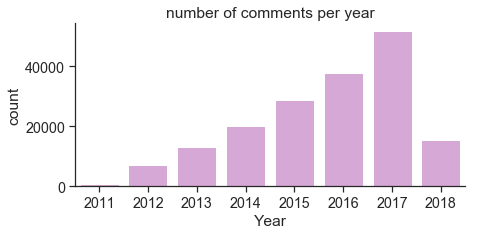

In [21]:
sns.set(style='ticks', font_scale=1.3)
plt.figure(figsize=(7,3))
sns.countplot(data=comments_df,
              x='Year',
              color='plum')
plt.title('number of comments per year')
sns.despine()

In [132]:
print(len(comments_df.index))

comments_df = comments_df.loc[~comments_df.index.duplicated(keep='first')]

print(len(comments_df.index))

174741
174534


<br><br>

# Sample data

In [22]:
for i in range(0, 20):
    print(i)
    _sampled_df = posts_df.sample(n=len(posts_df), replace=True)
    _sampled_df.to_csv(base_path + '/sampled_posts.' + str(i) + '.csv')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [23]:
samples = [pd.read_csv(base_path + '/sampled_posts.' + str(i) + '.csv') for i in range(0, 20)]

len(samples)

20

<br><br>

# Comments per post

Comments can reply to either posts or other comments.

In the ```parent_id``` field for comments, **t3** refers to **posts** and **t1** refers to **comments**.

In [24]:
parent_replies_dict = {}

for i, _row in comments_df.iterrows():
    _parent_id = str(_row['parent_id'].split('_')[-1])
    if _parent_id not in parent_replies_dict:
        parent_replies_dict[_parent_id] = []
    parent_replies_dict[_parent_id].append(_row['id'])
    
len(parent_replies_dict)

106440

1.641685456595265


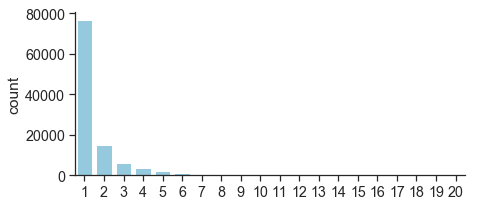

In [25]:
num_replies_list = [len(_replies) for _parent_id, _replies in parent_replies_dict.items()]

print(np.mean(num_replies_list))

sns.set(style='ticks', font_scale=1.3)
plt.figure(figsize=(7,3))
sns.countplot([n for n in num_replies_list if n < 21],
              color='skyblue')
sns.despine()

In [26]:
def get_number_of_replies(parent_id, parent_replies_dict):
    if parent_id in parent_replies_dict:
        return len(parent_replies_dict[parent_id])
    return 0


def get_replies(parent_id, parent_replies_dict):
    if parent_id in parent_replies_dict:
        return parent_replies_dict[parent_id]
    return []


posts_df['Number of Comments'] = posts_df.apply(lambda _row: get_number_of_replies(_row['id'], 
                                                                                   parent_replies_dict), axis = 1)

posts_df['Comments'] = posts_df.apply(lambda _row: get_replies(_row['id'], 
                                                               parent_replies_dict), axis = 1)
    
posts_df.sample(5)

,author,created_utc,gilded,id,link_flair_text,name,num_comments,over_18,permalink,title,selftext,url,ups,downs,Year,Number of Comments,Comments
id,,,,,,,,,,,,,,,,,
15e1yx,meyamashi,1356382652,0.0,15e1yx,NaN,NaN,0,f,/r/birthcontrol/comments/15e1yx/they_are_comin...,They are coming for your birth control: Where ...,NaN,http://www.rhrealitycheck.org/article/2012/12/...,1.0,0.0,2012,0,[]
4d0tjf,Quadsynth,1459587180,0.0,4d0tjf,Mistake or Risk?,t3_4d0tjf,4,f,/r/birthcontrol/comments/4d0tjf/need_a_peace_o...,Need a peace of mind,"I'm mainly looking for peace of mind, me and m...",https://www.reddit.com/r/birthcontrol/comments...,1.0,0.0,2016,2,"[d1mwe1v, d1myzjo]"
46xit1,ann_droid_,1456091871,0.0,46xit1,Side Effects!?,t3_46xit1,1,f,/r/birthcontrol/comments/46xit1/long_periods_o...,Long periods on mini pill,Have been taking mini pill for just over a yea...,https://www.reddit.com/r/birthcontrol/comments...,1.0,0.0,2016,1,[d08m2iq]
2971nz,snowfey,1403825417,0.0,2971nz,NaN,t3_2971nz,0,f,/r/birthcontrol/comments/2971nz/side_effects_a...,Side effects after going off the patch,"This isn't a question, this is me losing my mi...",http://www.reddit.com/r/birthcontrol/comments/...,2.0,0.0,2014,0,[]
4ggfex,LittleHm,1461632212,0.0,4ggfex,Experience,t3_4ggfex,3,f,/r/birthcontrol/comments/4ggfex/tips_for_survi...,Tips for surviving Nexplanon?,"Note: This is my first form of BC, I'm a 19F\n...",https://www.reddit.com/r/birthcontrol/comments...,1.0,0.0,2016,3,"[d2helzx, d2hk5r4, d2i4sor]"


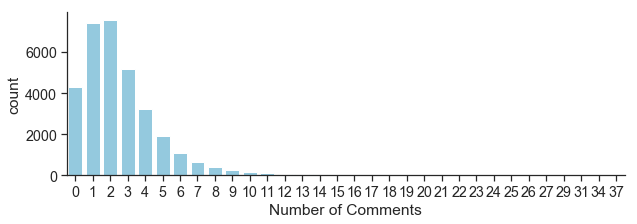

In [27]:
sns.set(style='ticks', font_scale=1.3)
plt.figure(figsize=(10,3))
sns.countplot(data=posts_df,
              x='Number of Comments',
              color='skyblue')
sns.despine()

In [28]:
comments_df['Number of Comments'] = comments_df.apply(lambda _row: get_number_of_replies(_row['id'], 
                                                                                         parent_replies_dict), axis = 1)

comments_df['Comments'] = comments_df.apply(lambda _row: get_replies(_row['id'], 
                                                                     parent_replies_dict), axis = 1)
    
comments_df.sample(5)

,author,body,controversiality,created_utc,gilded,id,link_id,parent_id,permalink,retrieved_on,score,stickied,subreddit,subreddit_id,ups,downs,Year,Number of Comments,Comments
id,,,,,,,,,,,,,,,,,,,
cdzrkdo,fuk_dapolice,i'm sorry I don't have any advice but you seem...,0,1386823431,0,cdzrkdo,t3_1so7u3,t3_1so7u3,NaN,1.428261e+09,2,NaN,birthcontrol,t5_2snsq,2.0,0.0,2013,1,[ce0w6az]
d0dg1sn,Silly_Wizzy,There are three standard options for emergency...,0,1456420888,0,d0dg1sn,t3_47jork,t1_d0dfoa4,NaN,1.458734e+09,4,f,birthcontrol,t5_2snsq,4.0,NaN,2016,2,"[d0dgo2d, d0dgt7j]"
d2etezj,lateda1990,Interesting..' I am currently living outside t...,0,1461456122,0,d2etezj,t3_4g5mcb,t1_d2erzeo,NaN,1.463648e+09,1,f,birthcontrol,t5_2snsq,1.0,NaN,2016,1,[d2eulsp]
deh6c01,dreamsooz,Hey! I'm glad that it went well ! I also got a...,0,1488578602,0,deh6c01,t3_5xba0s,t3_5xba0s,NaN,1.491186e+09,1,f,birthcontrol,t5_2snsq,NaN,NaN,2017,0,[]
ckxa7mu,LevyWife,[these are the drugs known to interfere with N...,0,1412146970,0,ckxa7mu,t3_2hyb9i,t1_ckx5r5z,NaN,1.426740e+09,2,NaN,birthcontrol,t5_2snsq,2.0,0.0,2014,0,[]


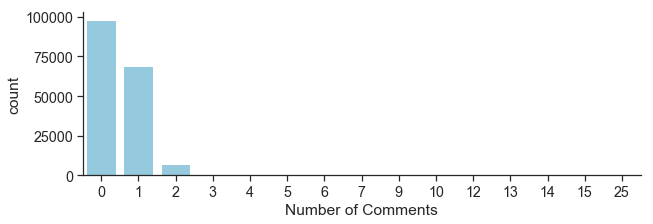

In [29]:
sns.set(style='ticks', font_scale=1.3)
plt.figure(figsize=(10,3))
sns.countplot(data=comments_df,
              x='Number of Comments',
              color='skyblue')
sns.despine()

<br><br>

# Users

In [30]:
user_posts_dict = {}

for i, _row in posts_df.iterrows():
    if _row['author'] not in user_posts_dict:
        user_posts_dict[_row['author']] = []
    user_posts_dict[_row['author']].append(_row['id'])
    
num_posts_list = [len(_posts) for _user, _posts in user_posts_dict.items()]

print(np.mean(num_posts_list))

np.mean(num_posts_list), np.std(num_posts_list), max(num_posts_list)

1.8721023640119347


(1.8721023640119347, 56.456279084123196, 7450)

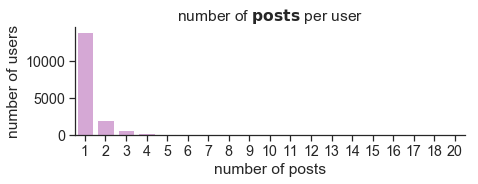

In [31]:
sns.set(style='ticks', font_scale=1.3)
plt.figure(figsize=(7,2))
sns.countplot([n for n in num_posts_list if n < 21],
              color='plum')
plt.title('number of ' + r'$\bf{posts}$ per user')
plt.xlabel('number of posts')
plt.ylabel('number of users')
sns.despine()

In [32]:
user_comments_dict = {}

for i, _row in comments_df.iterrows():
    if _row['author'] not in user_comments_dict:
        user_comments_dict[_row['author']] = []
    user_comments_dict[_row['author']].append(_row['id'])
    
num_comments_list = [len(_comments) for _user, _comments in user_comments_dict.items()]

np.mean(num_comments_list), np.std(num_comments_list), max(num_comments_list)

(7.875118301861282, 116.22958513642654, 13662)

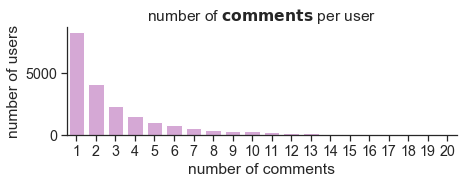

In [33]:
sns.set(style='ticks', font_scale=1.3)
plt.figure(figsize=(7,2))
sns.countplot([n for n in num_comments_list if n < 21],
              color='plum')
plt.title('number of ' + r'$\bf{comments}$ per user')
plt.xlabel('number of comments')
plt.ylabel('number of users')
sns.despine()

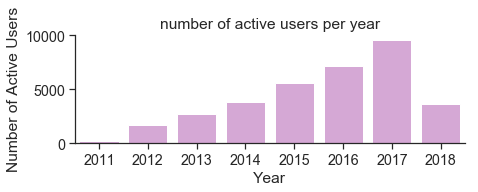

In [34]:
# number of users per year

year_users_dict = defaultdict(list)

for i, _row in posts_df.iterrows():
    year_users_dict[_row['Year']].append(_row['author'])
for i, _row in comments_df.iterrows():
    year_users_dict[_row['Year']].append(_row['author'])
   
dicts_to_plot = []
for _year, _users in year_users_dict.items():
    dicts_to_plot.append({'Year': _year,
                          'Number of Active Users': len(list(set(_users)))})
df_to_plot = pd.DataFrame(dicts_to_plot)
    
sns.set(style='ticks', font_scale=1.3)
plt.figure(figsize=(7,2))
sns.barplot(data=df_to_plot,
            x='Year',
            y='Number of Active Users',
            color='plum')
plt.title('number of active users per year')
sns.despine()

<br><br>

# Topic modeling (posts)

In [47]:
training_documents = []
years = []
flairs = [] 
post_ids = []

for i, _row in posts_df.iterrows():
    if not pd.isnull(_row['selftext']):
        training_documents.append(little_mallet_wrapper.process_string(_row['selftext']))
        years.append(_row['Year'])
        flairs.append(_row['link_flair_text'])
        post_ids.append(_row['id'])
        
len(training_documents), len(years), len(flairs), len(post_ids)

(31087, 31087, 31087, 31087)

In [48]:
num_topics = 30

training_data_path           = output_directory_path + '/training.posts.txt'
formatted_training_data_path = output_directory_path + '/mallet.posts.training'
model_path                   = output_directory_path + '/mallet.posts.model.' + str(num_topics)
topic_keys_path              = output_directory_path + '/mallet.posts.topic_keys.' + str(num_topics)
topic_distributions_path     = output_directory_path + '/mallet.posts.topic_distributions.' + str(num_topics)

In [323]:
little_mallet_wrapper.train_topic_model(MALLET_PATH,
                                        training_data_path,
                                        formatted_training_data_path,
                                        model_path,
                                        topic_keys_path,
                                        topic_distributions_path,
                                        training_documents,
                                        num_topics)

Importing data...
Training topic model...
Removing temporary files...


In [49]:
topics = little_mallet_wrapper.load_topic_keys(topic_keys_path)

for i, t in enumerate(topics):
    print(i, '\t', ' '.join(t[:10]))

0 	 know would thanks help much advice question thank find sorry
1 	 like really know get want feel even going thing would
2 	 num pain insertion iud felt cramps like took cervix day
3 	 num period days numth day started cycle since got first
4 	 num period days periods bleeding months spotting first cramps month
5 	 num depo shot bleeding months stop get time since period
6 	 deleted nexplanon implant arm removed got implanon inserted anyone getting
7 	 nuvaring week ring patch period num put new time one
8 	 pill num take day took taking time hours pills night
9 	 use condoms num using pill sex pregnancy pregnant would method
10 	 pills week pack period pill num start taking placebo new
11 	 period pregnancy test pregnant num month negative last took since
12 	 num pill acne taking tri generic ortho skin switched months
13 	 doctor went said told back appointment get time didn one
14 	 mood feel anxiety depression like swings months started time feeling
15 	 bleeding spotting period 

In [50]:
topic_distributions = little_mallet_wrapper.load_topic_distributions(topic_distributions_path)

len(topic_distributions), len(topic_distributions[0])

(31076, 30)

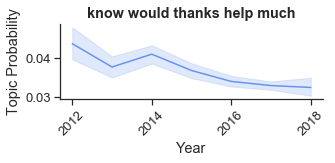

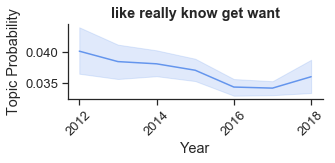

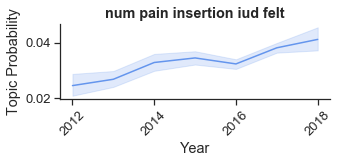

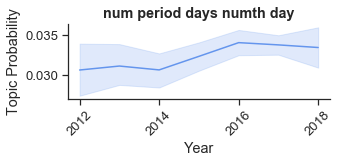

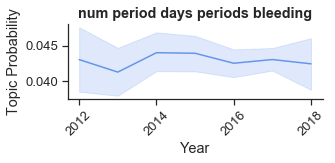

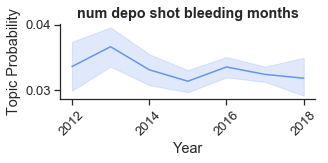

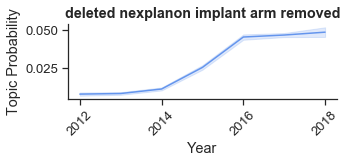

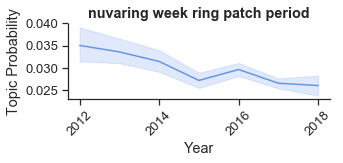

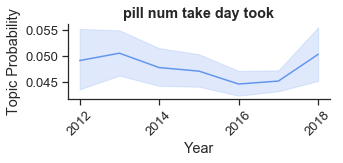

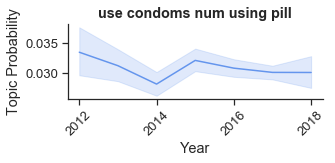

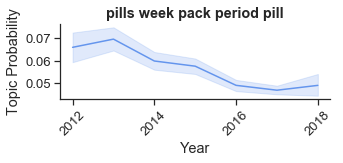

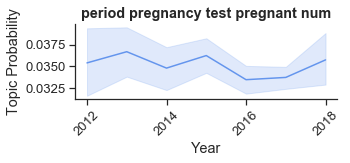

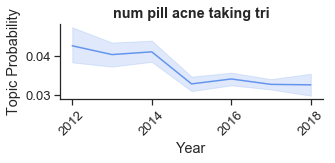

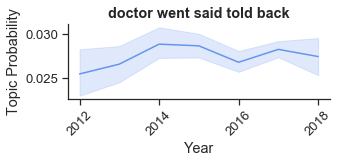

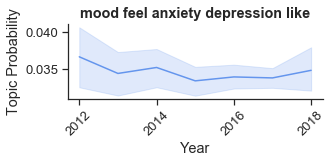

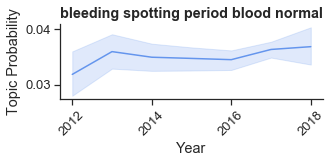

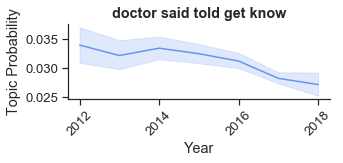

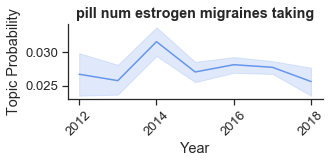

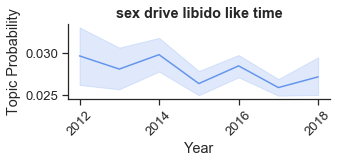

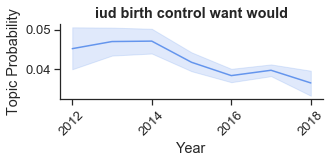

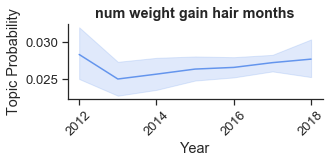

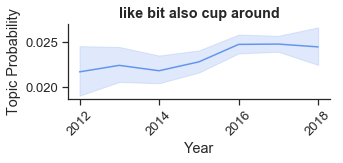

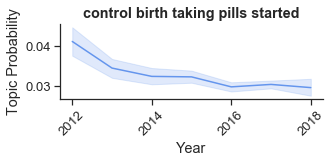

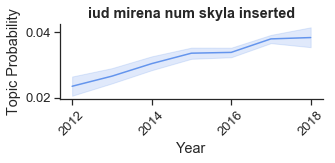

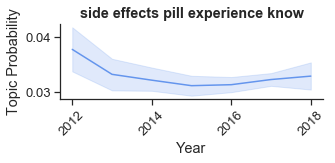

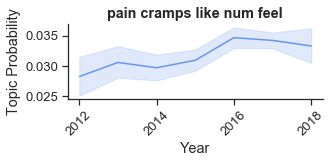

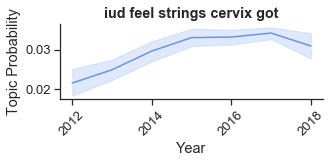

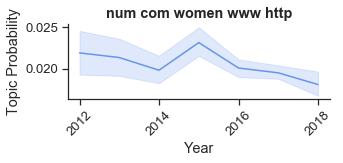

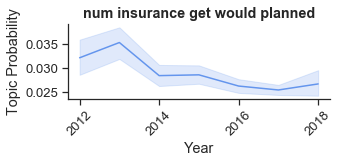

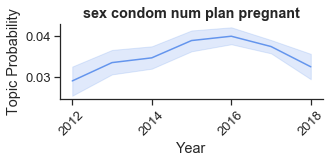

In [51]:
for _topic_index, _topic_words in enumerate(topics):
    
    dicts_to_plot = []
    for _year, _topic_distribution in zip(years, topic_distributions):
        if _year not in [2011]:
            dicts_to_plot.append({'Year': _year,
                                  'Topic Probability': _topic_distribution[_topic_index]})
    df_to_plot = pd.DataFrame(dicts_to_plot)
    
    sns.set(style='ticks', font_scale=1.2)
    plt.figure(figsize=(5, 2.5))
    sns.lineplot(data=df_to_plot,
                x='Year',
                y='Topic Probability', 
                color='cornflowerblue')
    plt.title(' '.join(_topic_words[:5]), fontweight='bold')
    plt.xticks(rotation=45)
    sns.despine()
    plt.tight_layout()
    plt.show()

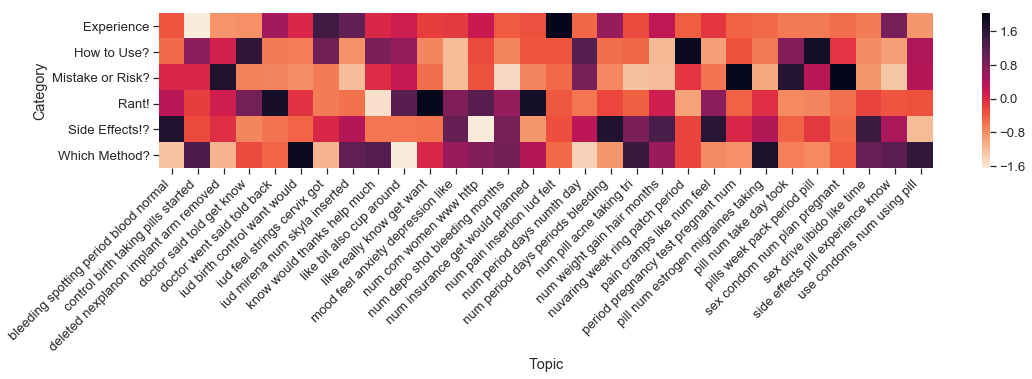

In [52]:
target_labels = ['Which Method?', 'Experience', 'How to Use?', 'Mistake or Risk?', 'Rant!', 'Side Effects!?']

little_mallet_wrapper.plot_categories_by_topics_heatmap(flairs,
                                                        topic_distributions,
                                                        topics, 
                                                        output_directory_path + '/flairs_by_topics.pdf',
                                                        target_labels=target_labels,
                                                        dim=(16,5.5))

In [53]:
post_topic_distribution_dict = {post_ids[i]: _distribution 
                                for i, _distribution in enumerate(topic_distributions)}
    
len(post_topic_distribution_dict)

31076

<br><br>

# Topic modeling (comments)

In [40]:
training_documents = []
years = []
parent_ids = [] 
comment_ids = []

for i, _row in comments_df.iterrows():
    if not pd.isnull(_row['body']):
        training_documents.append(little_mallet_wrapper.process_string(_row['body']))
        years.append(_row['Year'])
        parent_ids.append(_row['parent_id'])
        comment_ids.append(_row['id'])
        
len(training_documents), len(years), len(parent_ids), len(comment_ids)

(174738, 174738, 174738, 174738)

In [41]:
num_topics = 30

training_data_path           = output_directory_path + '/training.comments.txt'
formatted_training_data_path = output_directory_path + '/mallet.comments.training'
model_path                   = output_directory_path + '/mallet.comments.model.' + str(num_topics)
topic_keys_path              = output_directory_path + '/mallet.comments.topic_keys.' + str(num_topics)
topic_distributions_path     = output_directory_path + '/mallet.comments.topic_distributions.' + str(num_topics)

In [341]:
little_mallet_wrapper.train_topic_model(MALLET_PATH,
                                        training_data_path,
                                        formatted_training_data_path,
                                        model_path,
                                        topic_keys_path,
                                        topic_distributions_path,
                                        training_documents,
                                        num_topics)

Importing data...
Training topic model...
Removing temporary files...


In [42]:
topics = little_mallet_wrapper.load_topic_keys(topic_keys_path)

for i, t in enumerate(topics):
    print(i, '\t', ' '.join(t[:10]))

0 	 strings feel iud cervix check like place around uterus sure
1 	 num www http com org https women reddit bedsider contraceptive
2 	 pill take num time taking day hours every pills fine
3 	 want would like get know think really something going make
4 	 sex mood anxiety drive feel depression like pill swings made
5 	 like didn really know get never said got think thing
6 	 doctor would ask see said call get told talk appointment
7 	 like sex get also use infection could discharge make used
8 	 thank thanks much know really better hope good definitely yeah
9 	 use condoms num method effective using pregnancy condom methods pregnant
10 	 iud mirena copper hormonal skyla hormones paragard iuds years uterus
11 	 implant nexplanon arm like mine insertion get feel removed little
12 	 num period months spotting days month weeks got first bleeding
13 	 num acne pill skin years generic ortho months back switched
14 	 control birth hormonal pills method form take would like pill
15 	 good peopl

In [43]:
topic_distributions = little_mallet_wrapper.load_topic_distributions(topic_distributions_path)

len(topic_distributions), len(topic_distributions[0])

(174729, 30)

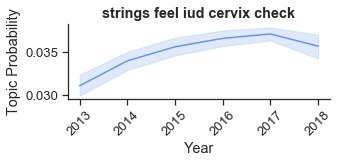

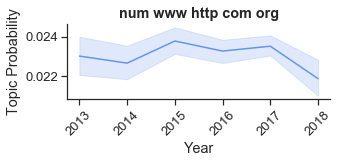

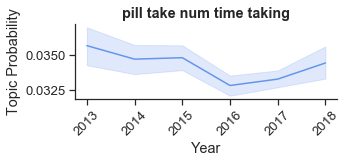

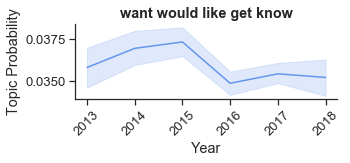

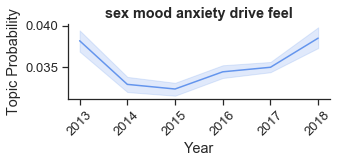

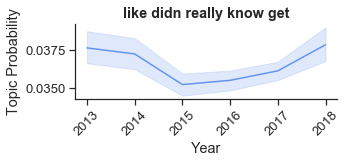

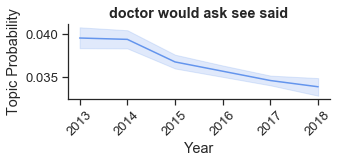

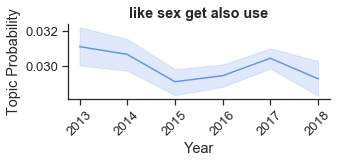

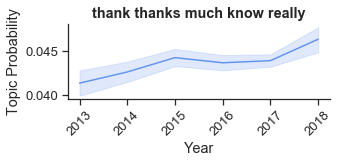

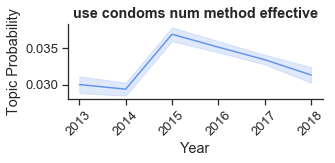

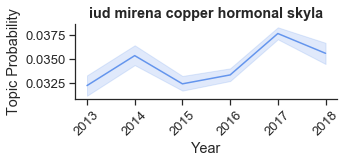

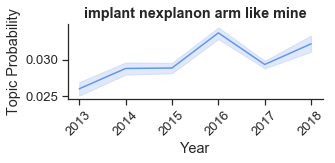

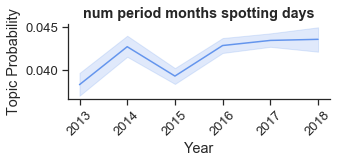

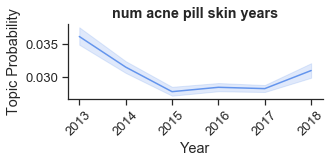

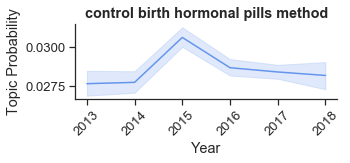

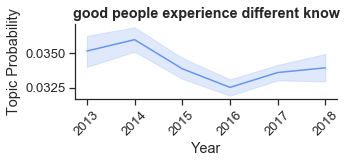

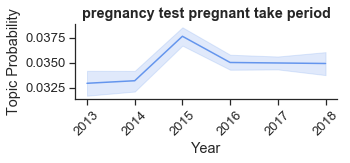

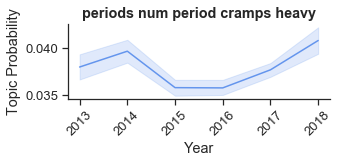

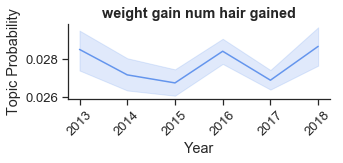

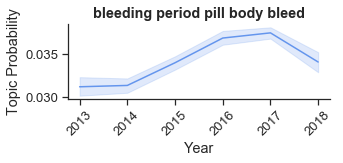

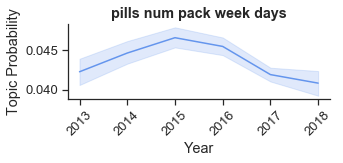

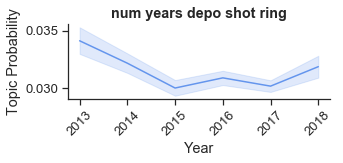

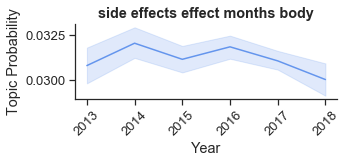

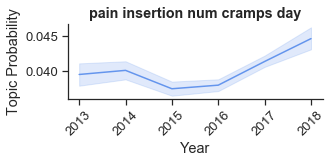

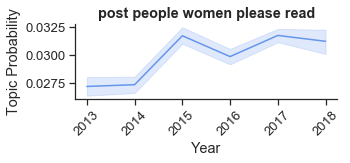

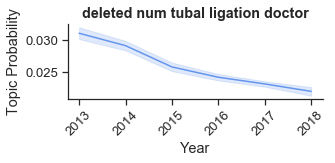

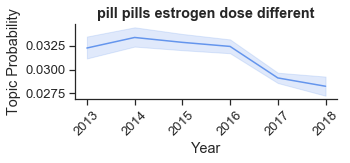

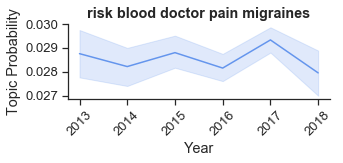

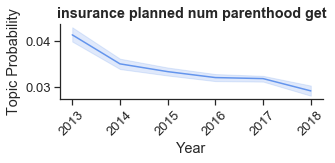

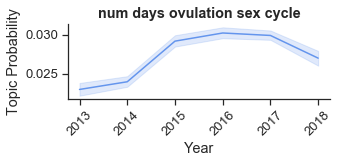

In [44]:
for _topic_index, _topic_words in enumerate(topics):
    
    dicts_to_plot = []
    for _year, _topic_distribution in zip(years, topic_distributions):
        if _year not in [2011, 2012]:
            dicts_to_plot.append({'Year': _year,
                                  'Topic Probability': _topic_distribution[_topic_index]})
    df_to_plot = pd.DataFrame(dicts_to_plot)
    
    sns.set(style='ticks', font_scale=1.2)
    plt.figure(figsize=(5, 2.5))
    sns.lineplot(data=df_to_plot,
                x='Year',
                y='Topic Probability', 
                color='cornflowerblue')
    plt.title(' '.join(_topic_words[:5]), fontweight='bold')
    plt.xticks(rotation=45)
    sns.despine()
    plt.tight_layout()
    plt.show()

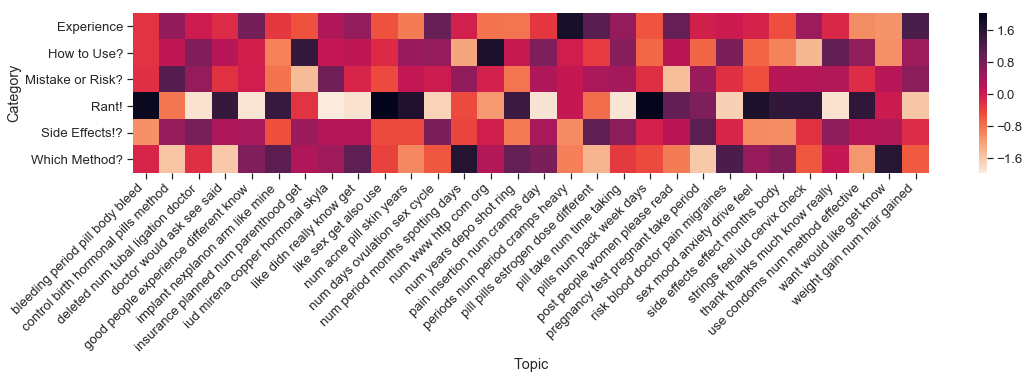

In [45]:
target_labels = ['Which Method?', 'Experience', 'How to Use?', 'Mistake or Risk?', 'Rant!', 'Side Effects!?']

little_mallet_wrapper.plot_categories_by_topics_heatmap(flairs,
                                                        topic_distributions,
                                                        topics, 
                                                        output_directory_path + '/flairs_by_topics.pdf',
                                                        target_labels=target_labels,
                                                        dim=(16,5.5))

In [46]:
comment_topic_distribution_dict = {comment_ids[i]: _distribution 
                                   for i, _distribution in enumerate(topic_distributions)}
    
len(comment_topic_distribution_dict)

174522

<br><br>

# N-grams over time

TODO: Run over 20 samples

In [295]:
target_ngrams = ['iud', 'pill', 'shot', 'mirena', 'the']
ngram_year_count_dict = defaultdict(lambda: defaultdict(int))
year_count_dict = defaultdict(int)

for i, _row in posts_df.iterrows():   
    year_count_dict[_row['Year']] += 1    
    for _ngram in target_ngrams:
        if not pd.isnull(_row['selftext']) and _ngram in _row['selftext'].lower():
            ngram_year_count_dict[_ngram][_row['Year']] += 1

ngram_year_percent_dict = defaultdict(lambda: defaultdict(float))
for _ngram, _year_count_dict in ngram_year_count_dict.items():
    for _year, _count in _year_count_dict.items():
        ngram_year_percent_dict[_ngram][_year] = _count / float(year_count_dict[_year])

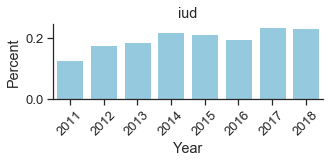

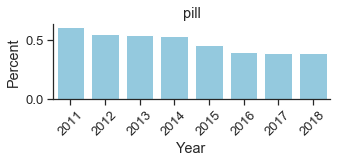

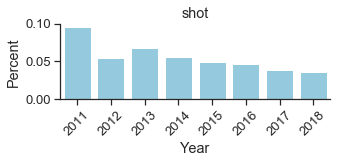

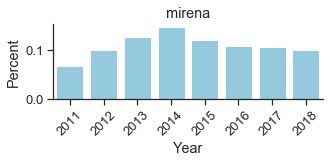

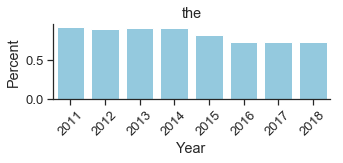

In [296]:
for _ngram in target_ngrams:
    
    dicts_to_plot = [{'N-gram': _ngram, 'Year': _year, 'Percent': _percent} 
                     for _year, _percent in ngram_year_percent_dict[_ngram].items()]
    df_to_plot = pd.DataFrame(dicts_to_plot)
    
    sns.set(style='ticks', font_scale=1.2)
    plt.figure(figsize=(5, 2.5))
    sns.barplot(data=df_to_plot,
                  x='Year',
                  y='Percent',
                  color='skyblue')
    plt.xticks(rotation=45)
    plt.title(_ngram)
    sns.despine()
    plt.tight_layout()
    plt.show()

<br><br>

# User role clustering

### Features
- number of posts created
- number of comments created
- topics of comments created
- topics of posts created
- topics of posts replied to
- mean number of likes on posts created
- mean number of likes on comments created
- mean number of likes on posts replied to
- mean number of likes on comments replied to
- mean number of comments on posts created
- mean number of comments on posts replied to
- flairs of posts created
- flairs of posts replied to
- mean comment length
- mean post length
- number of days between first and last activity
- number of links shared
- number of questions

TODO: Divide comments by replying to others / replying to self (network features)

In [54]:
users = list(set(list(user_posts_dict.keys()) + list(user_comments_dict.keys())))

len(users)

27924

In [163]:
def get_num_posts(user, user_posts_dict):
    if user in user_posts_dict:
        return len(user_posts_dict[user])
    return 0


def get_num_comments(user, user_comments_dict):
    if user in user_comments_dict:
        return len(user_comments_dict[user])
    return 0    
    

def get_upvotes(user, user_content_dict, df):   
    votes_list = []
    if user in user_content_dict:
        for _content_id in user_content_dict[user]:
            if _content_id in df.index and not pd.isnull(df.loc[_content_id]['ups']):
                votes_list.append(df.loc[_content_id]['ups'])       
    if votes_list:
        return np.mean(votes_list)
    return 0


def get_downvotes(user, user_content_dict, df):
    votes_list = []
    if user in user_content_dict:
        for _content_id in user_content_dict[user]:
            if _content_id in df.index and not pd.isnull(df.loc[_content_id]['ups']):
                votes_list.append(df.loc[_content_id]['ups'])       
    if votes_list:
        return np.mean(votes_list)
    return 0


def get_posts_topics(user, user_posts_dict, post_topic_distribution_dict, num_topics):   
    if user in user_posts_dict:
        topic_distributions = [post_topic_distribution_dict[_post_id] 
                               for _post_id in user_posts_dict[user]
                               if _post_id in post_topic_distribution_dict]
        if topic_distributions:
            return list(np.mean(topic_distributions, axis=0))
    return [0]*num_topics


def get_comments_topics(user, user_comments_dict, comment_topic_distribution_dict, num_topics):   
    if user in user_comments_dict:
        topic_distributions = [comment_topic_distribution_dict[_comment_id] 
                               for _comment_id in user_comments_dict[user]
                               if _comment_id in comment_topic_distribution_dict]
        if topic_distributions:
            return list(np.mean(topic_distributions, axis=0))
    return [0]*num_topics


def get_num_questions_in_posts(user, user_posts_dict, posts_df):
    num_questions_list = []
    if user in user_posts_dict:
        for _content_id in user_posts_dict[user]:
            if _content_id in posts_df.index and not pd.isnull(posts_df.loc[_content_id]['selftext']):
                _text = posts_df.loc[_content_id]['selftext']  
                _num_questions = len(re.findall(r'[A-Za-z\s]+[?]', _text))
                num_questions_list.append(_num_questions)
    if num_questions_list:
        return np.mean(num_questions_list)
    return 0
  

def get_num_questions_in_comments(user, user_comments_dict, comments_df):
    num_questions_list = []
    if user in user_comments_dict:
        for _content_id in user_comments_dict[user]:
            if _content_id in comments_df.index and not pd.isnull(comments_df.loc[_content_id]['body']):
                _text = comments_df.loc[_content_id]['body']  
                _num_questions = len(re.findall(r'[A-Za-z\s]+[?]', _text))
                num_questions_list.append(_num_questions)
    if num_questions_list:
        return np.mean(num_questions_list)
    return 0


def get_num_links_in_posts(user, user_posts_dict, posts_df):
    num_links_list = []
    if user in user_posts_dict:
        for _content_id in user_posts_dict[user]:
            if _content_id in posts_df.index and not pd.isnull(posts_df.loc[_content_id]['selftext']):
                _text = posts_df.loc[_content_id]['selftext']  
                _num_links = len(re.findall(r'http', _text))
                num_links_list.append(_num_links)
    if num_links_list:
        return np.mean(num_links_list)
    return 0
  

def get_num_links_in_comments(user, user_comments_dict, comments_df):
    num_links_list = []
    if user in user_comments_dict:
        for _content_id in user_comments_dict[user]:
            if _content_id in comments_df.index and not pd.isnull(comments_df.loc[_content_id]['body']):
                _text = comments_df.loc[_content_id]['body']  
                _num_links = len(re.findall(r'http', _text))
                num_links_list.append(_num_links)
    if num_links_list:
        return np.mean(num_links_list)
    return 0

In [164]:
users = random.sample(users, 1000)

In [165]:
num_posts_features = []
num_comments_features = []

upvotes_for_posts_features = []
upvotes_for_comments_features = []

downvotes_for_posts_features = []
downvotes_for_comments_features = []

num_comments_on_posts_features = []
num_comments_on_comments_features = []

posts_topics_features = []
comments_topics_features = []

num_questions_in_posts_features = []
num_questions_in_comments_features = []

num_links_in_posts_features = []
num_links_in_comments_features = []

for i, _user in enumerate(users):
    
    if i % 1000 == 0:
        print(str(datetime.now()) + ': Processed ' + str(i) + ' out of ' + str(len(users)))
    
    num_posts_features.append(get_num_posts(_user, user_posts_dict))
    num_comments_features.append(get_num_comments(_user, user_comments_dict))
      
    upvotes_for_posts_features.append(get_upvotes(_user, user_posts_dict, posts_df))
    upvotes_for_comments_features.append(get_upvotes(_user, user_comments_dict, comments_df))
    downvotes_for_posts_features.append(get_downvotes(_user, user_posts_dict, posts_df))
    downvotes_for_comments_features.append(get_downvotes(_user, user_comments_dict, comments_df))
    
    num_questions_in_posts_features.append(get_num_questions_in_posts(_user, user_posts_dict, posts_df))
    num_questions_in_comments_features.append(get_num_questions_in_comments(_user, user_comments_dict, comments_df))

    num_links_in_posts_features.append(get_num_links_in_posts(_user, user_posts_dict, posts_df))
    num_links_in_comments_features.append(get_num_links_in_comments(_user, user_comments_dict, comments_df))

    posts_topics_features.append(get_posts_topics(_user, user_posts_dict, post_topic_distribution_dict, num_topics))
    comments_topics_features.append(get_comments_topics(_user, user_comments_dict, comment_topic_distribution_dict, num_topics))
    
len(num_posts_features), len(num_comments_features)

2020-02-27 17:07:12.461621: Processed 0 out of 1000


(1000, 1000)

In [166]:
feature_lists = []

for i in range(0, len(users)):
    feature_lists.append([])
    feature_lists[-1].append(num_posts_features[i])
    feature_lists[-1].append(num_comments_features[i])
    feature_lists[-1].append(upvotes_for_posts_features[i])
    feature_lists[-1].append(upvotes_for_comments_features[i])
    feature_lists[-1].append(downvotes_for_posts_features[i])
    feature_lists[-1].append(downvotes_for_comments_features[i])
    feature_lists[-1].append(num_questions_in_posts_features[i])
    feature_lists[-1].append(num_questions_in_comments_features[i])
    feature_lists[-1].append(num_links_in_posts_features[i])
    feature_lists[-1].append(num_links_in_comments_features[i])
    feature_lists[-1] += posts_topics_features[i]
    feature_lists[-1] += comments_topics_features[i]
    
len(feature_lists), len(feature_lists[5]), feature_lists[9]

(1000,
 70,
 [1,
  0,
  0,
  0,
  0,
  0,
  1.0,
  0,
  0.0,
  0,
  0.0043859649122807015,
  0.0043859649122807015,
  0.0043859649122807015,
  0.030701754385964914,
  0.0043859649122807015,
  0.0043859649122807015,
  0.0043859649122807015,
  0.0043859649122807015,
  0.0043859649122807015,
  0.0043859649122807015,
  0.0043859649122807015,
  0.0043859649122807015,
  0.0043859649122807015,
  0.0043859649122807015,
  0.030701754385964914,
  0.0043859649122807015,
  0.0043859649122807015,
  0.16228070175438597,
  0.0043859649122807015,
  0.0043859649122807015,
  0.0043859649122807015,
  0.0043859649122807015,
  0.10964912280701755,
  0.030701754385964914,
  0.0043859649122807015,
  0.0043859649122807015,
  0.0043859649122807015,
  0.0043859649122807015,
  0.5307017543859649,
  0.0043859649122807015,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0])

In [167]:
num_clusters = 15

kmeans = KMeans(n_clusters=num_clusters).fit(feature_lists)

In [168]:
cluster_users_dict = defaultdict(list)

for _label, _user in zip(kmeans.labels_, users):
    cluster_users_dict[_label].append(_user)
    
len(cluster_users_dict)

15

In [169]:
for _cluster in range(0, num_clusters):
    print(_cluster, '\t', len(cluster_users_dict[_cluster]))

0 	 180
1 	 1
2 	 3
3 	 84
4 	 1
5 	 27
6 	 162
7 	 12
8 	 347
9 	 3
10 	 2
11 	 54
12 	 7
13 	 115
14 	 2


In [170]:
for _user in random.sample(cluster_users_dict[0], 10):
    if _user in user_posts_dict:
        for _post_id in user_posts_dict[_user]:
            print('POST: ' + posts_df.loc[_post_id]['title'])
    print('---------------------------------------')
    if _user in user_comments_dict:
        for _comment_id in user_comments_dict[_user]:
            print('COMMENT: ' + comments_df.loc[_comment_id]['body'])        
    print('=======================================')

POST: Basal body temperature help!
---------------------------------------
COMMENT: Thank you so much! really appreciate the response :)
POST: Breakthrough bleeding for two weeks now?
---------------------------------------
POST: Scared and clueless about Birthcontrol!
---------------------------------------
COMMENT: Hi paintedlady318,

I'm sorry you feel that way. But you don't know anything about me and Im sure you have a lot more life experience then me. However I'm am happy with my life and I'm not a little immature girl who dosent know what she's doing. I've thought long and hard about my life and the people in it. So I can understand your concern as I am quite young. But I assure you that I can handle myself :) thanks x
POST: Have a Nexplanon appointment today and I'm not entirely sure if I want to follow through -- help!
POST: Took a couple pills late this week but "corrected" it -- is it okay if he finishes inside me?
---------------------------------------
POST: Can I start it

In [171]:
for _user in random.sample(cluster_users_dict[3], 10):
    if _user in user_posts_dict:
        for _post_id in user_posts_dict[_user]:
            print('POST: ' + posts_df.loc[_post_id]['title'])
    print('---------------------------------------')
    if _user in user_comments_dict:
        for _comment_id in user_comments_dict[_user]:
            print('COMMENT: ' + comments_df.loc[_comment_id]['body'])        
    print('=======================================')

---------------------------------------
COMMENT: You could always try getting fitted for a diaphragm. It's a barrier method and mixed with spermicidal jelly it's relatively effective.

According to Planned Parenthood: If women always use the diaphragm as directed, 6 out of 100 will become pregnant each year. If women don't always use the diaphragm as directed, 12 out of 100 will become pregnant each year.

If you mix this with pulling out you minimize your chances greatly. 

[Here's](http://www.plannedparenthood.org/health-topics/birth-control/birth-control-effectiveness-chart-22710.htm) a list of birth control options from Planned Parenthood though. You may also consider a non hormonal copper IUD which lasts for up to 10 years with high rates of effectiveness. (But it's a bit expensive depending on where you go to get it inserted)
COMMENT: I completely understand about having the money for an IUD. That's currently the situation I'm in and why I'm on pills. 

But if you're worried abou

In [1]:
# TODO: How to interpret / evaluate these clusters? Feature analysis, etc.